<a href="https://colab.research.google.com/github/liliwfxa/take_home_1/blob/main/Fetch_Takehome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
pip install pandasql

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
from dateutil.relativedelta import relativedelta
import pandasql as psql

In [68]:
#Load the datasets

# Define column data types for Products
products_dtypes = {
    "CATEGORY_1": str,
    "CATEGORY_2": str,
    "CATEGORY_3": str,
    "CATEGORY_4": str,
    "MANUFACTURER": str,
    "BRAND": str,
    "BARCODE": str
}

# Define column data types for Transactions
transactions_dtypes = {
    "RECEIPT_ID": str,
    "STORE_NAME": str,
    "USER_ID": str,
    "BARCODE": str,
    "FINAL_SALE": str,
    "FINAL_QUANTITY": str,
    "PURCHASE_DATE": str,
    "SCAN_DATE": str
}

# Define column data types for User
user_dtypes = {
    "ID": str,
    "CREATED_DATE": str,
    "BIRTH_DATE": str,
    "GENDER": str,
    "STATE": str,
    "LANGUAGE": str
}

# Load Products CSV
Original_Products = pd.read_csv("PRODUCTS_TAKEHOME .csv", dtype=products_dtypes)

# Load Transactions CSV
Original_Transactions = pd.read_csv("TRANSACTION_TAKEHOME.csv", dtype=transactions_dtypes)

# Load User CSV with parsed dates
Original_User = pd.read_csv("USER_TAKEHOME.csv",dtype=user_dtypes)

In [69]:
Products = Original_Products.copy()
Transactions = Original_Transactions.copy()
User = Original_User.copy()

# Q1: Explore the Data

**Data Quality Overview & Key Challenges**

As part of the data exploration process, I reviewed the Users, Transactions, and Products datasets to assess their integrity and usability. Several data quality issues and challenges were identified, which impact the reliability of downstream analysis.

**1️⃣ Key Data Quality Issues**

1. High Volume of Unmatched Records

  88% of Transactions (44,000 records) contain USER_IDs not found in the Users table.

  38.82% of Transactions (19,412 records) have BARCODEs that do not match any Products.

  Impact: Inability to link users to purchases or identify product performance accurately.

2. Timestamp Misalignment

  SCAN_DATE, CREATED_DATE, and BIRTH_DATE were in UTC (with "Z" suffix). PURCHASE_DATE had no time zone, leading to inconsistencies.

  Impact: Incorrect time-based analysis without standardization.

3. Duplicate & Conflicting Records

  25,389 duplicate RECEIPT_IDs found in Transactions.

  57 conflicting BARCODEs where product details differ.

  Impact: Data inconsistencies that affect revenue tracking and product insights.



4. Primary Key Ambiguity

  RECEIPT_ID alone is not a unique identifier—a single transaction can contain multiple products.

  Solution: Primary key should be (RECEIPT_ID, BARCODE) instead.

5. Significant Missing Values

  Users Table: BIRTH_DATE, STATE, LANGUAGE, GENDER missing in large proportions.

  Products Table: Missing CATEGORY_4, MANUFACTURER, BRAND.

  Transactions Table: 11.46% of transactions lack BARCODEs`.

  Impact: Limited segmentation, inaccurate product classifications, and incomplete financial data.

6. Outliers & Anomalies

  Extreme FINAL_QUANTITY values (up to 276 units per transaction).

  Fractional FINAL_QUANTITY values, suggesting weight-based pricing or data entry errors.

  Transactions with near-zero unit prices, likely due to promotions or system issues.

  Impact: Misleading revenue analysis and potential pricing errors.

7. Unrealistic User Age Entries

  Many users with ages 0-10 or 100+, and placeholder birthdates like 1900-12-31.

  Impact: Distorted demographic insights affecting marketing segmentation.

8. Unexpected Negative Time Differences

  Cases where SCAN_DATE occurs before PURCHASE_DATE, indicating possible system lags or data entry errors.
  Impact: Errors in purchase journey analysis and timing-based reports.

**2️⃣ Fields That Are Challenging to Understand**

1. BARCODE Gaps → 11.33% missing in Transactions—unclear if some purchases bypass barcode capture.

2. CATEGORY_4 → Missing in 92% of products—unclear if cause of lacking of granular classification or optional field.

3. Gender Distribution → Significantly more female users—unclear if this results from Fetch’s marketing strategy or actual user behavior.

4. FINAL_QUANTITY Behavior → Some transactions contain fractional units—unclear if Fetch allows weight-based purchases.

5. FINAL_SALE Calculation → Prices do not always scale with quantity, possibly due to discounts or bulk pricing.

6. BIRTH_DATE Patterns → Placeholder dates raise questions about data accuracy.





## 1.Initial Data Inspection

**Objective**: Conduct an initial data quality check across the three datasets (Products, Transactions, Users).

**Steps:**

Step1: Display summary statistics for numerical columns in the tables

Step 2: Display detailed column information, including data types and missing values, for three tables



In [70]:
#Step1: Display summary statistics for numerical columns in the tables
print(Products.describe())
print(Transactions.describe())
print(Transactions.describe())

               CATEGORY_1 CATEGORY_2        CATEGORY_3 CATEGORY_4  \
count              845441     844128            784986      67459   
unique                 27        121               344        127   
top     Health & Wellness      Candy  Confection Candy  Lip Balms   
freq               512695     121036             56965       9737   

                    MANUFACTURER      BRAND       BARCODE  
count                     619078     619080        841527  
unique                      4354       8122        841525  
top     PLACEHOLDER MANUFACTURER  REM BRAND  017000329260  
freq                       86902      20813             2  
                                  RECEIPT_ID PURCHASE_DATE  \
count                                  50000         50000   
unique                                 24440            89   
top     bedac253-2256-461b-96af-267748e6cecf    2024-06-15   
freq                                      12           774   

                        SCAN_DATE STORE_NAM

In [71]:
#Step 2: Display detailed column information, including data types and missing values, for three tables
print(Products.info())
print(Transactions.info())
print(User.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CATEGORY_1    845441 non-null  object
 1   CATEGORY_2    844128 non-null  object
 2   CATEGORY_3    784986 non-null  object
 3   CATEGORY_4    67459 non-null   object
 4   MANUFACTURER  619078 non-null  object
 5   BRAND         619080 non-null  object
 6   BARCODE       841527 non-null  object
dtypes: object(7)
memory usage: 45.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RECEIPT_ID      50000 non-null  object
 1   PURCHASE_DATE   50000 non-null  object
 2   SCAN_DATE       50000 non-null  object
 3   STORE_NAME      50000 non-null  object
 4   USER_ID         50000 non-null  object
 5   BARCODE         44238 non-null  obje

## 2.Merge Three Datasets to Check Data Consistency



**Objective:**

Merge Transactions, Users, and Products datasets to ensure proper linkage.

Identify missing or mismatched records before proceeding with analysis.

**Steps:**

Step 1: Merge three datasets to check merged datasets

Step 2: Identifying Mismatched Data







In [72]:
#Step 1: Merge three datasets to check merged datasets

# Remove rows where BARCODE is NaN
Transactions_cleaned = Transactions.dropna(subset=["BARCODE"])
Products_cleaned = Products.dropna(subset=["BARCODE"])

# Perform the join
Transactions_Products_User_Merge = (
    Transactions_cleaned
    .merge(User, left_on="USER_ID", right_on="ID", how="inner")
    .merge(Products, on="BARCODE", how="inner")
)

# Check data statistics
print(f"Total Transactions before filtering: {len(Transactions)}")
print(f"Total Transactions after filtering: {len(Transactions_cleaned)}")
print(f"Final Merged Data Shape: {Transactions_Products_User_Merge.shape}")


Total Transactions before filtering: 50000
Total Transactions after filtering: 44238
Final Merged Data Shape: (144, 20)


In [73]:
#Step 2: Identifying Mismatched Data

# Check Transactions where USER_ID does not exist in Users table
unmatched_users = Transactions_cleaned[~Transactions_cleaned["USER_ID"].isin(User["ID"])]
print(f"Transactions with USER_IDs not found in Users table: {unmatched_users.shape[0]} ({unmatched_users.shape[0] / Transactions.shape[0]:.2%})")

# Check Transactions where BARCODE does not exist in Products table
unmatched_barcodes = Transactions_cleaned[~Transactions_cleaned["BARCODE"].isin(Products_cleaned["BARCODE"])]
print(f"Transactions with BARCODEs not found in Products table: {unmatched_barcodes.shape[0]} ({unmatched_barcodes.shape[0] / Transactions.shape[0]:.2%})")


Transactions with USER_IDs not found in Users table: 44000 (88.00%)
Transactions with BARCODEs not found in Products table: 19412 (38.82%)


### Data Quality Issues 1:Low Data Usability

**Findings:**

88% of Transactions (44,000 records) have USER_ID that do not exist in the Users table.

38.82% of Transactions (19,412 records) have BARCODE that do not match any records in the Products table.

This means that a majority of transactions cannot be linked to user or product information, making it difficult to analyze customer behavior or product performance accurately.

**Possible Reasons:**

1️⃣ Incomplete or Outdated User Data

2️⃣ External or Historical Transactions

3️⃣ Missing or Incorrect Product Mappings

4️⃣ Data Pipeline Issues

**Next Steps:**

We need input from the Data Engineering team to determine why such a large percentage of transactions do not match Users or Products.

## 3.Check Data Type

**Objective:**

Ensure all date fields are in a consistent Central Time Zone (CST) format.

Convert numeric fields into appropriate types for analysis.

**Steps:**

Step 1: Convert Date Columns to Datetime Format

Step 2:Convert Numeric Fields

Step 3: Validate Data Types After Conversion




In [74]:
# Step 1: Convert Date Columns to Datetime Format

# Ensure Pandas correctly interprets object-type columns before conversion
User = User.infer_objects()
Transactions = Transactions.infer_objects()

# Define Central Time Zone (America/Chicago)
central = pytz.timezone('America/Chicago')

# Convert PURCHASE_DATE to datetime format (no timezone needed)
Transactions["PURCHASE_DATE"] = pd.to_datetime(Transactions["PURCHASE_DATE"], errors='coerce')

# Convert SCAN_DATE to datetime format and adjust to Central Time
Transactions["SCAN_DATE"] = pd.to_datetime(Transactions["SCAN_DATE"], errors='coerce').dt.tz_convert(central)

# Convert CREATED_DATE and BIRTH_DATE in User table to Central Time
User["CREATED_DATE"] = pd.to_datetime(User["CREATED_DATE"], errors='coerce').dt.tz_convert(central)
User["BIRTH_DATE"] = pd.to_datetime(User["BIRTH_DATE"], errors='coerce').dt.tz_convert(central)

# Remove timezone information to standardize with PURCHASE_DATE
User["CREATED_DATE"] = User["CREATED_DATE"].dt.tz_localize(None)
User["BIRTH_DATE"] = User["BIRTH_DATE"].dt.tz_localize(None)
Transactions["SCAN_DATE"] = pd.to_datetime(Transactions["SCAN_DATE"], errors='coerce').dt.tz_localize(None)

###Data Quality Issues 2: Time Zone Standardization

**Findings**：

SCAN_DATE, CREATED_DATE, and BIRTH_DATE were in UTC (with "Z" suffix).
PURCHASE_DATE had no time zone, leading to inconsistencies.

**Assumption and Solution**:

Fetch Rewards operates in Central Standard Time (CST), so all timestamps should be standardized to CST.

In [75]:
#Step 2:Convert Numeric Fields

# Convert FINAL_SALE and FINAL_QUANTITY to numeric format to enable calculations
Transactions["FINAL_SALE"] = pd.to_numeric(Transactions["FINAL_SALE"], errors="coerce")
Transactions["FINAL_QUANTITY"] = pd.to_numeric(Transactions["FINAL_QUANTITY"], errors="coerce")

In [76]:
#Step 3: Validate Data Types After Conversion
print(User.dtypes)
print(Transactions.dtypes)

ID                      object
CREATED_DATE    datetime64[ns]
BIRTH_DATE      datetime64[ns]
STATE                   object
LANGUAGE                object
GENDER                  object
dtype: object
RECEIPT_ID                object
PURCHASE_DATE     datetime64[ns]
SCAN_DATE         datetime64[ns]
STORE_NAME                object
USER_ID                   object
BARCODE                   object
FINAL_QUANTITY           float64
FINAL_SALE               float64
dtype: object


## 4.Check Duplicates

**Objective:**

Identify and remove duplicate records across the Products, Transactions, and Users datasets.

Ensure primary keys are unique (e.g., BARCODE, RECEIPT_ID, USER_ID).

Address data integrity issues caused by duplicate records.

**Steps:**

Step 1: Check exact duplicates and Check duplicates in the primary key of each table

Step 2: Drop exact duplicate rows from each table

Step 3: Handle Duplicate BARCODEs in Products

Step 4: Handle Duplicate RECEIPT_IDs in Transactions

Step 5: Verify removal



In [77]:
#Step 1: Check Duplicates

# Check for duplicate records for full rows
duplicates_products = Products.duplicated().sum()
duplicates_transactions = Transactions.duplicated().sum()
duplicates_users = User.duplicated().sum()

# Check duplicates in the primary key of each table
# Filter out non-NaN BARCODEs
non_nan_products = Products[~Products["BARCODE"].isna()]
# Count duplicate primary keys in Products (BARCODE)
duplicate_products_pk = non_nan_products['BARCODE'].duplicated().sum()
# Count duplicate primary keys in Transactions
duplicate_transactions_pk = Transactions['RECEIPT_ID'].duplicated().sum()
# Count duplicate primary keys in User
duplicate_users_pk = User['ID'].duplicated().sum()

# Display results
print(f"Total duplicate full rows in Products: {duplicates_products}")
print(f"Duplicate primary keys in Products (BARCODE): {duplicate_products_pk}")

print(f"Total duplicate full rows in Transactions: {duplicates_transactions}")
print(f"Duplicate primary keys in Transactions (RECEIPT_ID): {duplicate_transactions_pk}")

print(f"Total duplicate full rows in User: {duplicates_users}")
print(f"Duplicate primary keys in User (ID): {duplicate_users_pk}")

Total duplicate full rows in Products: 57
Duplicate primary keys in Products (BARCODE): 2
Total duplicate full rows in Transactions: 171
Duplicate primary keys in Transactions (RECEIPT_ID): 25560
Total duplicate full rows in User: 0
Duplicate primary keys in User (ID): 0


###Data Quality Issue 3: Duplicates

**1.Duplicates in Transactions**

**Findings**: 171 duplicate full rows and 25,389 duplicate RECEIPT_IDs in the Transactions table.

**Solution**: Kept records with the most non-null values and removed duplicates.

**2.Duplicate BARCODEs in Products**

**Findings**: 57 duplicate full rows. Two BARCODEs (052336919068 and 017000329260) had conflicting product details.

**Solution**: Removed one duplicate for consistency.

In [78]:
# Step 2: Drop exact duplicate rows from each table
Products = Products.drop_duplicates().reset_index(drop=True)
Transactions = Transactions.drop_duplicates().reset_index(drop=True)

In [79]:
#Step 3: Handle Duplicate BARCODEs in Products

# Step 3.1 Identify duplicate records in Products based on BARCODE (excluding NaN)
duplicate_mask_products = Products[~Products["BARCODE"].isna()].duplicated(subset=['BARCODE'], keep=False)

# Filter dataset to show only these duplicate records
duplicated_products = Products[~Products["BARCODE"].isna()][duplicate_mask_products]

# Sort by BARCODE for easier comparison
duplicated_products = duplicated_products.sort_values(by=['BARCODE'])

# Display a sample of 10 duplicate records
duplicated_products.head(10)


,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
213331,Health & Wellness,Hair Care,Hair Color,NaN,HENKEL,SCHWARZKOPF,017000329260
304009,Health & Wellness,Hair Care,Hair Color,NaN,HENKEL,GÖT2B,017000329260
28421,Health & Wellness,Hair Care,Hair Color,NaN,HENKEL,SCHWARZKOPF,052336919068
709566,Health & Wellness,Hair Care,Hair Color,NaN,HENKEL,GÖT2B,052336919068


In [95]:
# Step 3.2 Drop duplicates based on BARCODE while keeping the first occurrence
# Drop duplicates based on BARCODE while keeping the first occurrence
Products = Products.drop_duplicates(subset=['BARCODE'], keep='first').reset_index(drop=True)
# Verify that no duplicate BARCODEs remain
remaining_duplicates = Products.duplicated(subset=['BARCODE']).sum()
if remaining_duplicates == 0:
    print("✅ No duplicate BARCODEs remain after deduplication.")
else:
    print(f"⚠️ {remaining_duplicates} duplicate BARCODEs still exist. Further cleaning needed.")


✅ No duplicate BARCODEs remain after deduplication.


In [81]:
#Step 4: Handle Duplicate RECEIPT_IDs in Transactions

# Step 4.1 Identify duplicate records based on RECEIPT_ID
duplicate_mask = Transactions.duplicated(subset=['RECEIPT_ID'], keep=False)

# Filter the dataset to show only these duplicate records
duplicated_records = Transactions[duplicate_mask]

# Sort records to make sure duplicates are next to each other for comparison
duplicated_records = duplicated_records.sort_values(by=['RECEIPT_ID', 'BARCODE', 'FINAL_SALE'])

# Select the first 5 unique RECEIPT_IDs that have duplicates
unique_duplicate_receipts = duplicated_records['RECEIPT_ID'].unique()[:5]

# Display records grouped by RECEIPT_ID (Only for the first 5)
for receipt_id in unique_duplicate_receipts:
    print(f"==== RECEIPT_ID: {receipt_id} ====")
    display(duplicated_records[duplicated_records['RECEIPT_ID'] == receipt_id])  # Use display() in Jupyter Notebook
    print("\n")




==== RECEIPT_ID: 0000d256-4041-4a3e-adc4-5623fb6e0c99 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
41464,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 09:19:06.539,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.0,1.54
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 09:19:06.539,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.0,NaN




==== RECEIPT_ID: 0001455d-7a92-4a7b-a1d2-c747af1c8fd3 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 04:50:24.206,ALDI,62c08877baa38d1a1f6c211a,NaN,NaN,1.49
39205,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 04:50:24.206,ALDI,62c08877baa38d1a1f6c211a,NaN,1.0,1.49




==== RECEIPT_ID: 00017e0a-7851-42fb-bfab-0baa96e23586 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
25901,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 10:38:56.813,WALMART,60842f207ac8b7729e472020,078742229751,1.0,2.54
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 10:38:56.813,WALMART,60842f207ac8b7729e472020,078742229751,1.0,NaN




==== RECEIPT_ID: 000239aa-3478-453d-801e-66a82e39c8af ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 06:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,NaN,3.49
41372,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 06:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.0,3.49




==== RECEIPT_ID: 00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
43118,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 10:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,047900501183,1.0,5.29
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 10:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,047900501183,1.0,NaN


In [82]:
# Step 4.2: Identify duplicated (RECEIPT_ID, BARCODE) pairs

duplicate_pairs = Transactions[Transactions.duplicated(subset=['RECEIPT_ID', 'BARCODE'], keep=False)]
print(f"Number of duplicated (RECEIPT_ID, BARCODE) pairs: {duplicate_pairs.shape[0]}")

# Sort by RECEIPT_ID and BARCODE to keep related records together
duplicate_pairs = duplicate_pairs.sort_values(by=['RECEIPT_ID', 'BARCODE', 'FINAL_SALE'])

# Select the first 5 unique (RECEIPT_ID, BARCODE) pairs
unique_duplicate_pairs = duplicate_pairs[['RECEIPT_ID', 'BARCODE']].drop_duplicates().head(5)

# Display records grouped by (RECEIPT_ID, BARCODE) (Only for the first 5 groups)
for _, row in unique_duplicate_pairs.iterrows():
    receipt_id = row['RECEIPT_ID']
    barcode = row['BARCODE']
    print(f"==== RECEIPT_ID: {receipt_id}, BARCODE: {barcode} ====")
    display(duplicate_pairs[(duplicate_pairs['RECEIPT_ID'] == receipt_id) & (duplicate_pairs['BARCODE'] == barcode)])  # Use display() in Jupyter Notebook
    print("\n")



Number of duplicated (RECEIPT_ID, BARCODE) pairs: 49829
==== RECEIPT_ID: 0000d256-4041-4a3e-adc4-5623fb6e0c99, BARCODE: 015300014978 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
41464,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 09:19:06.539,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.0,1.54
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 09:19:06.539,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.0,NaN




==== RECEIPT_ID: 0001455d-7a92-4a7b-a1d2-c747af1c8fd3, BARCODE: nan ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE




==== RECEIPT_ID: 00017e0a-7851-42fb-bfab-0baa96e23586, BARCODE: 078742229751 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
25901,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 10:38:56.813,WALMART,60842f207ac8b7729e472020,078742229751,1.0,2.54
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 10:38:56.813,WALMART,60842f207ac8b7729e472020,078742229751,1.0,NaN




==== RECEIPT_ID: 000239aa-3478-453d-801e-66a82e39c8af, BARCODE: 783399746536 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 06:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,NaN,3.49
41372,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 06:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.0,3.49




==== RECEIPT_ID: 00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1, BARCODE: 047900501183 ====


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
43118,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 10:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,047900501183,1.0,5.29
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 10:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,047900501183,1.0,NaN


In [83]:
# Step 4.3: Assign priority based on missing values in FINAL_SALE and FINAL_QUANTITY
Transactions['priority'] = Transactions[['FINAL_SALE', 'FINAL_QUANTITY']].isna().sum(axis=1)
#Ensures that the most complete record is retained in case of duplicates.

In [84]:
# Step 4.4: Rank transactions within the same (RECEIPT_ID, BARCODE) group based on priority
Transactions['rk'] = Transactions.groupby(['RECEIPT_ID', 'BARCODE'])['priority'].rank(method='first')
#Ensures that within each (RECEIPT_ID, BARCODE) pair, the best-quality transaction is identified.

In [85]:
# Step 4.5: Rank transactions within the same RECEIPT_ID group
Transactions['rk2'] = Transactions.groupby(['RECEIPT_ID'])['priority'].rank(method='first')

# If rk (ranking within RECEIPT_ID, BARCODE) exists, use it instead of rk2
Transactions['rk2'] = Transactions['rk2'].where(Transactions['rk'].isna(), Transactions['rk'])


In [86]:
# Step 4.6: Keep only records with the highest priority (lowest rk2 value)
Transactions_cleaned = Transactions[Transactions['rk2'] == 1].drop(columns=['priority', 'rk', 'rk2'])

# Update Transactions dataset
Transactions = Transactions_cleaned

In [96]:
# Verify removal
duplicates_products = Products.duplicated().sum()
duplicates_transactions = Transactions.duplicated().sum()
duplicates_users = User.duplicated().sum()

# Check for duplicates in the composite key (RECEIPT_ID, BARCODE)
duplicate_transactions_pk = Transactions.duplicated(subset=['RECEIPT_ID', 'BARCODE']).sum()
duplicate_users_pk = User['ID'].duplicated().sum()
remaining_duplicates_products_pk = Products.duplicated(subset=['BARCODE']).sum()

print(f"Remaining duplicate full rows in Products: {duplicates_products}")
print(f"Remaining duplicate full rows in Transactions: {duplicates_transactions}")
print(f"Remaining duplicate full rows in User: {duplicates_users}")
print(f"Remaining duplicate primary keys in Transactions (RECEIPT_ID, BARCODE pair): {duplicate_transactions_pk}")
print(f"Remaining duplicate primary keys in User (ID): {duplicate_users_pk}")
print(f"Remaining duplicate primary keys in Products (BARCODE): {remaining_duplicates_products_pk}")

Remaining duplicate full rows in Products: 0
Remaining duplicate full rows in Transactions: 0
Remaining duplicate full rows in User: 0
Remaining duplicate primary keys in Transactions (RECEIPT_ID, BARCODE pair): 0
Remaining duplicate primary keys in User (ID): 0
Remaining duplicate primary keys in Products (BARCODE): 0


### Data quality issues 4: Identifying the Correct Primary Key in Transactions

**Initial Assumption**:

 RECEIPT_ID appeared to be a primary key in Transactions, but duplicates were found.

**Further Investigation**:

These records had different BARCODE values and FINAL_SALE,meaning they likely represent different products purchased in the same transaction.

**Conclusion**:

RECEIPT_ID alone is not a valid primary key because a single receipt can contain multiple products.

The correct **primary key** for the Transactions table should be **(RECEIPT_ID, BARCODE)** to uniquely identify each product purchased in a transaction.

##4.Check missing values

**Objective:**

To assess the completeness of our data and identify potential data quality issues related to missing values. This will help determine whether missing values are random, systematically missing, or indicative of deeper data pipeline issues.

**Steps:**

Step 1: Check missing value percentage for each column in all three datasets

Step 2: Investigate missing BARCODEs in the Transactions table to further determine the cause.

Step 3: Investigate missing BARCODEs in the Transactions table to further determine the cause.



In [88]:
#Step 1: Check missing value percentage for each column in all three datasets
missing_percentage_products = (Products.isnull().sum() / len(Products)) * 100
missing_percentage_transactions = (Transactions.isnull().sum() / len(Transactions)) * 100
missing_percentage_users = (User.isnull().sum() / len(User)) * 100

# Display missing value percentages
missing_percentage_products, missing_percentage_transactions, missing_percentage_users

(CATEGORY_1       0.013128
 CATEGORY_2       0.168186
 CATEGORY_3       7.163040
 CATEGORY_4      92.021814
 MANUFACTURER    26.786029
 BRAND           26.785792
 BARCODE          0.469312
 dtype: float64,
 RECEIPT_ID         0.00000
 PURCHASE_DATE      0.00000
 SCAN_DATE          0.00000
 STORE_NAME         0.00000
 USER_ID            0.00000
 BARCODE           11.33925
 FINAL_QUANTITY     0.00000
 FINAL_SALE         0.00000
 dtype: float64,
 ID               0.000
 CREATED_DATE     0.000
 BIRTH_DATE       3.675
 STATE            4.812
 LANGUAGE        30.508
 GENDER           5.892
 dtype: float64)

In [89]:
#Step 2: Investigate missing BARCODEs in the Transactions table to further determine the cause.
transactions_nan_barcode = Transactions[Transactions["BARCODE"].isna()]
transactions_nan_barcode.describe()

,PURCHASE_DATE,SCAN_DATE,FINAL_QUANTITY,FINAL_SALE
count,2811,2811,2811.000000,2811.000000
mean,2024-07-21 00:10:14.727854848,2024-07-22 23:59:38.401361408,1.078744,4.896980
min,2024-06-12 00:00:00,2024-06-12 07:20:41.947000,0.040000,0.000000
25%,2024-07-03 00:00:00,2024-07-05 04:17:52.717499904,1.000000,1.290000
50%,2024-07-19 00:00:00,2024-07-20 15:12:52.248999936,1.000000,2.490000
75%,2024-08-07 00:00:00,2024-08-09 04:19:22.059499776,1.000000,4.555000
max,2024-09-08 00:00:00,2024-09-08 17:11:14.505000,12.000000,462.820000
std,NaN,NaN,0.490980,13.866098


In [90]:
#Step 3: Investigate missing BARCODEs in the Transactions table to further determine the cause.
products_nan_barcode = Products[Products["BARCODE"].isna()]
products_nan_barcode.describe()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
count,3968,3207,2119,219,3721,3721,0
unique,9,44,198,59,126,769,0
top,Health & Wellness,Skin Care,Body Wash,Lip Balms,COTY,ANNIE'S HOMEGROWN GROCERY,NaN
freq,2298,399,69,25,269,24,NaN


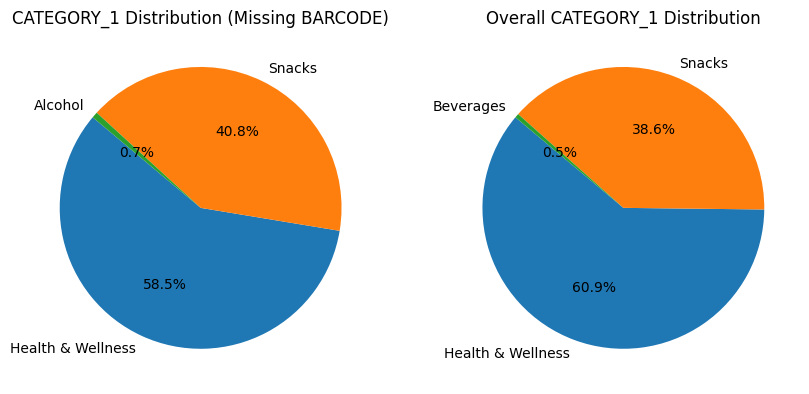

In [91]:
# Get CATEGORY_1 distribution for missing BARCODE records
products_nan_barcode = Products[Products["BARCODE"].isna()]
category_distribution = products_nan_barcode["CATEGORY_1"].value_counts().head(3)

# Get overall CATEGORY_1 distribution
overall_category_distribution = Products["CATEGORY_1"].value_counts().head(3)

# Create side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for missing BARCODE CATEGORY_1 distribution
axes[0].pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("CATEGORY_1 Distribution (Missing BARCODE)")

# Pie chart for overall CATEGORY_1 distribution
axes[1].pie(overall_category_distribution, labels=overall_category_distribution.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Overall CATEGORY_1 Distribution")

plt.show()

### Challenge to Understand 1: BARCODE Gaps

11.33% missing in Transactions—unclear if some purchases bypass barcode capture.

###Data Quality Issues 5: Missing Values in Products, Transactions, and Users


**Issue 1:** Missing values detected in multiple tables:

Products Table: CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND.

Users Table: BIRTH_DATE, STATE, LANGUAGE, GENDER.


**Assumptions:**

Some missing values (like CATEGORY_4) may not be errors but instead indicate a lack of granular classification.
STATE, LANGUAGE, BIRTH_DATE, and GENDER are missing in the Users table, likely due to optional registration fields.

**Solution:**

Kept categorical fields as NaN, since filling them arbitrarily could introduce bias.
Left numerical and datetime fields (BIRTH_DATE, FINAL_QUANTITY, FINAL_SALE) as NaN, ensuring data integrity for future analysis.

**Issue 2: Missing BARCODEs in Transactions and Products**

- 11.33% of BARCODEs are missing in Transactions and 0.47% in Products.  
- No clear pattern in missing BARCODEs in Transactions.  
- Missing BARCODEs in Products align with the overall CATEGORY_1 distribution, suggesting they may have never been assigned rather than lost.  

**Solution:**  
- Missing BARCODEs were flagged for review rather than filled, as they are critical for product identification.  

**Next Step:**  
- Verify with upstream sources whether missing BARCODEs are due to system errors or if they were never assigned.

##5.Field-Level Validation

**Objective**:

The goal of this section is to systematically examine the distribution of all columns to identify potential data anomalies, inconsistencies, and outliers that may impact analysis.

**Steps:**

Step 1: Plot distributions to check for categorical field anomalies

Step 2: Plot distributions to check for Datetime field anomalies

Step 3: Plot distributions to check for numerical field anomalies


### 5.1 Categories

In [99]:
print(User['GENDER'].unique())

['Female' nan 'Male' 'Non-Binary' 'Transgender' 'Prefer Not to Say'
 'Other' 'Unknown']


In [100]:
# Define mapping dictionary for gender standardization
gender_mapping = {
    'female': 'Female',
    'male': 'Male',
    'non_binary': 'Non-Binary',
    'Non-Binary': 'Non-Binary',
    'transgender': 'Transgender',
    'prefer_not_to_say': 'Prefer Not to Say',
    'Prefer not to say': 'Prefer Not to Say',
    "My gender isn't listed": 'Prefer Not to Say',
    'not_listed': 'Other',
    'Unspecified': 'Unknown',
    'not_specified': 'Unknown',
    'unknown': 'Unknown'
}

# Apply mapping to standardize GENDER values
User["GENDER"] = User["GENDER"].replace(gender_mapping)

# Check cleaned unique values
print(User['GENDER'].unique())

['Female' nan 'Male' 'Non-Binary' 'Transgender' 'Prefer Not to Say'
 'Other' 'Unknown']


In [101]:
#step 1: Plot distributions to check for categorical field anomalies
def plot_horizontal_bar(data, title, xlabel="Count", ylabel="Category"):
    plt.figure(figsize=(8, 6))
    plt.barh(data.index, data.values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.gca().invert_yaxis()  # Ensure the highest count is at the top
    plt.show()

In [102]:
# Analyze the distribution of each categorical column
category1_counts = Products["CATEGORY_1"].value_counts().head(10)
category2_counts = Products["CATEGORY_2"].value_counts().head(10)
category3_counts = Products["CATEGORY_3"].value_counts().head(10)
category4_counts = Products["CATEGORY_4"].value_counts().head(10)
manufacturer_counts = Products["MANUFACTURER"].value_counts().head(10)
brand_counts = Products["BRAND"].value_counts().head(10)
state_counts = User["STATE"].value_counts()
language_counts = User["LANGUAGE"].value_counts()
gender_counts = User["GENDER"].value_counts()

####Challenge to Understand 2: Understanding Product Category_1 Distribution

**Findings:**

The majority of products in the dataset fall under Health & Wellness and Snacks in CATEGORY_1. This raises questions about whether Fetch Rewards focuses on specific types of products.

**Possible Explanation:**

Fetch Rewards primarily partners with Consumer Packaged Goods (CPG) brands, which focus on consumables such as food, beverages, and personal care products. This could explain why categories like Health & Wellness and Snacks dominate the dataset while other retail categories (e.g., electronics or apparel) are underrepresented.

**Next Steps:**
Confirm with business stakeholders whether CATEGORY_1 distribution aligns with Fetch Rewards' brand partnerships and customer focus.

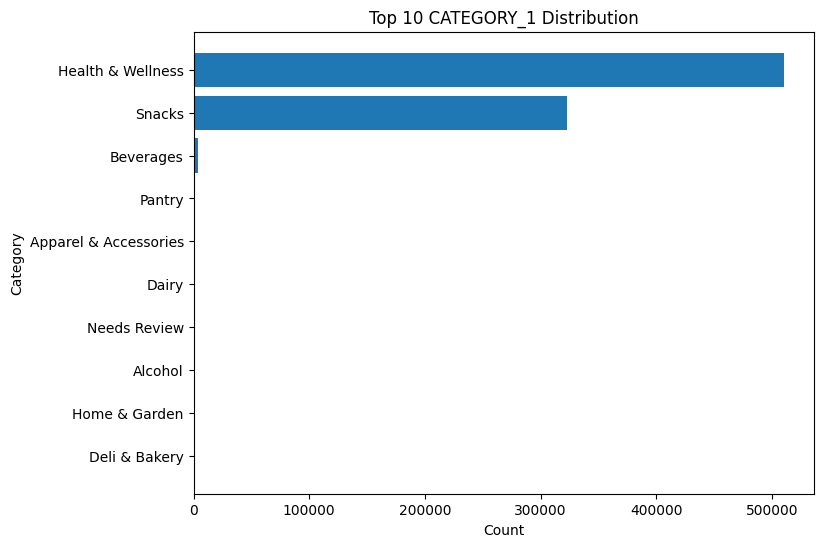

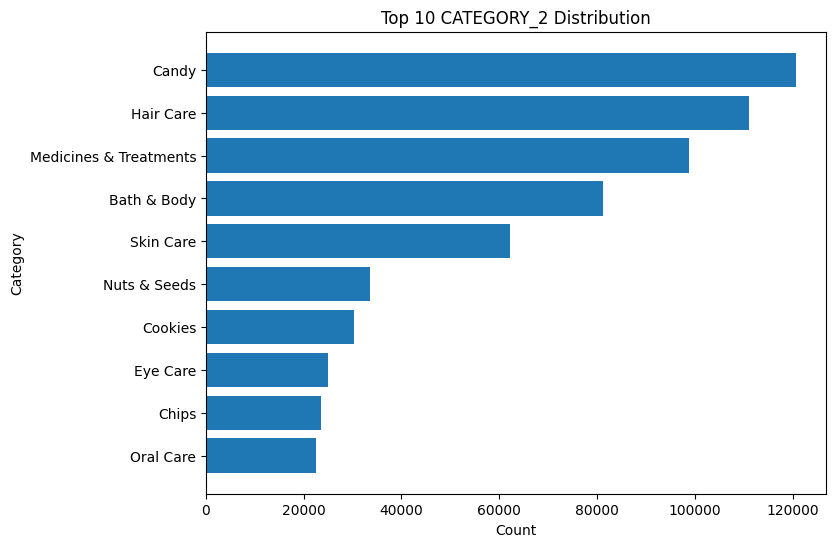

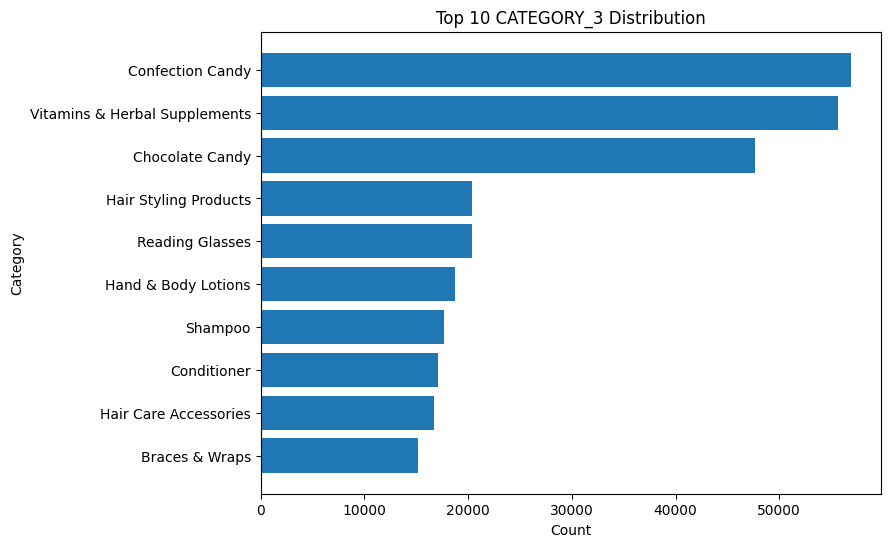

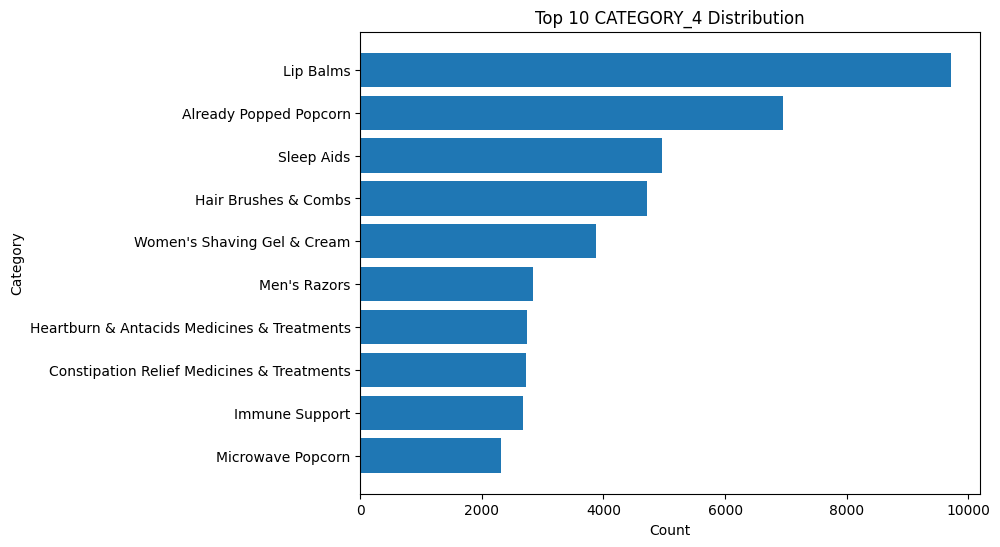

In [103]:
# Plot horizontal bar charts to check for categorical field anomalies
plot_horizontal_bar(category1_counts, "Top 10 CATEGORY_1 Distribution")
plot_horizontal_bar(category2_counts, "Top 10 CATEGORY_2 Distribution")
plot_horizontal_bar(category3_counts, "Top 10 CATEGORY_3 Distribution")
plot_horizontal_bar(category4_counts, "Top 10 CATEGORY_4 Distribution")

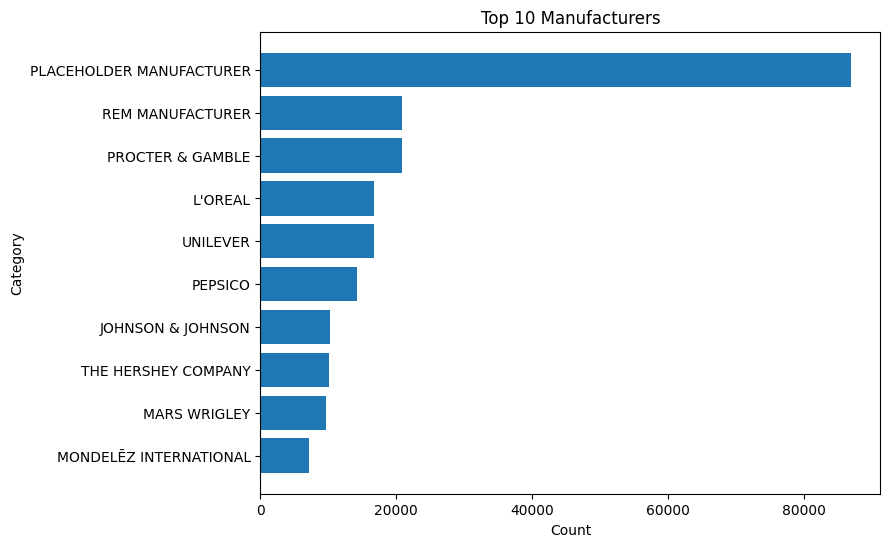

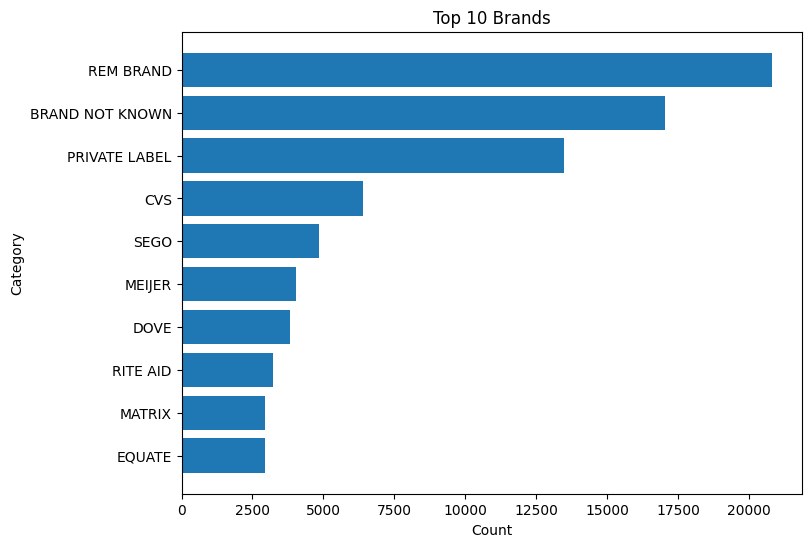

In [104]:
# Plot horizontal bar charts to check for categorical field anomalies
plot_horizontal_bar(manufacturer_counts, "Top 10 Manufacturers")
plot_horizontal_bar(brand_counts, "Top 10 Brands")

#### Challenging to Understand 3: User Gender Distribution

**Findings**:

The gender distribution in the dataset shows a significantly higher number of female users compared to male users. At first, this might seem unusual.

**Assumaption**:

Considering Fetch Rewards' business model, it is possible that **female users** are **more engaged** with rewards programs, leading to a higher representation in the dataset.

**Next Step:**

To confirm this, further analysis could be done on user behavior across genders, including purchase frequency and engagement levels with Fetch Rewards.

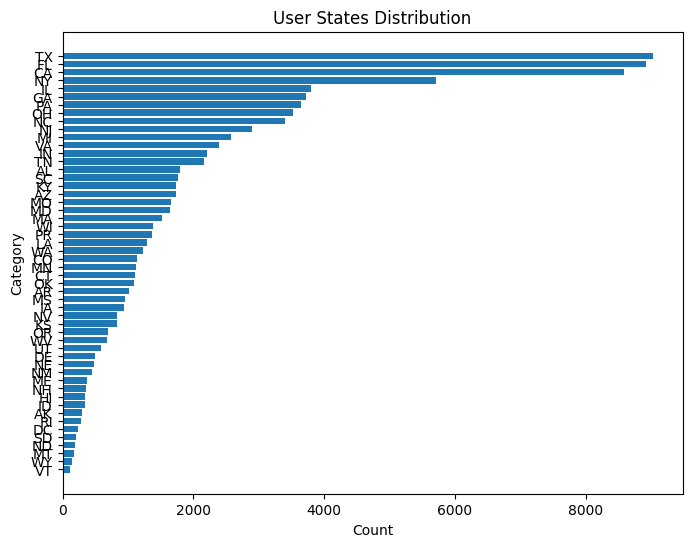

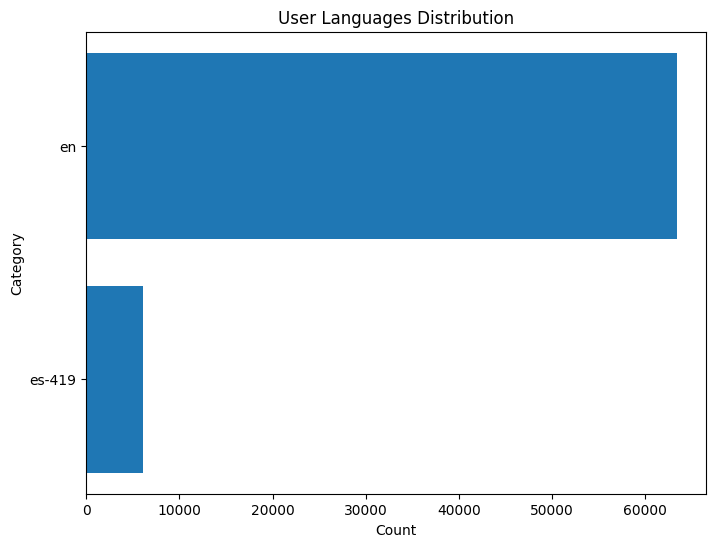

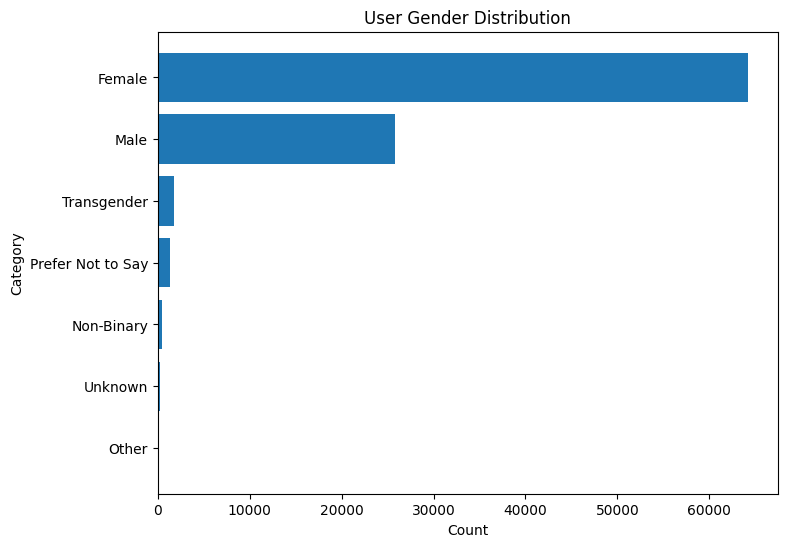

In [105]:
# Plot horizontal bar charts to check for categorical field anomalies
plot_horizontal_bar(state_counts, "User States Distribution")
plot_horizontal_bar(language_counts, "User Languages Distribution")
plot_horizontal_bar(gender_counts, "User Gender Distribution")

### 5.2 Datetime

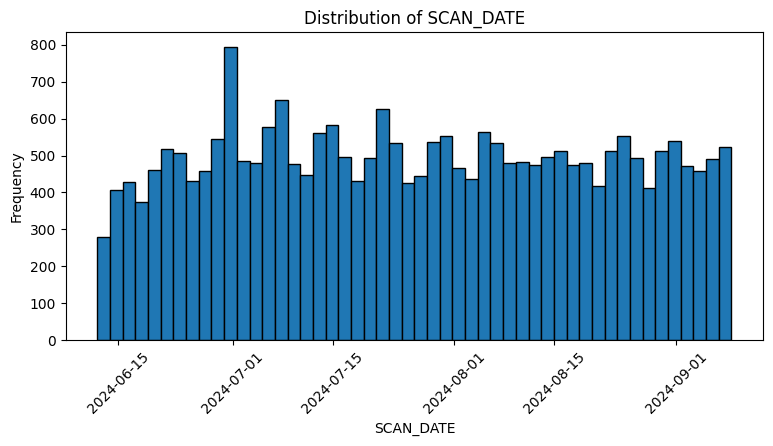

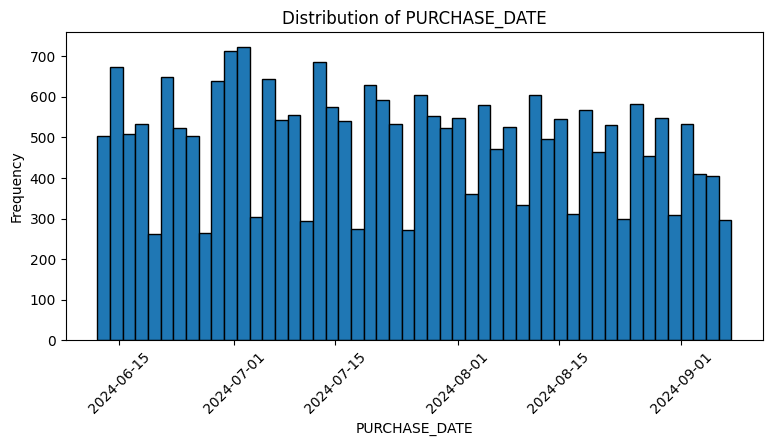

In [113]:
#Step 2: Plot distributions to check for Datetime field anomalies
# Plot SCAN_DATE distribution
plt.figure(figsize=(9, 4))
plt.hist(Transactions["SCAN_DATE"].dropna(), bins=50, edgecolor='black')
plt.xlabel("SCAN_DATE")
plt.ylabel("Frequency")
plt.title("Distribution of SCAN_DATE")
plt.xticks(rotation=45)
plt.show()

# Plot PURCHASE_DATE distribution
plt.figure(figsize=(9, 4))
plt.hist(Transactions["PURCHASE_DATE"].dropna(), bins=50, edgecolor='black')
plt.xlabel("PURCHASE_DATE")
plt.ylabel("Frequency")
plt.title("Distribution of PURCHASE_DATE")
plt.xticks(rotation=45)
plt.show()


#### Data Quality Issue 6: Unexpected Negative Time Differences

**Findings**:

Even after aligning all timestamps to CST, the difference between **SCAN_DATE and PURCHASE_DATE** still ranges from **-1 to 32 days**.

**Next Step**:

The presence of negative values is particularly concerning, as logically, a receipt should be scanned after the purchase occurs. This discrepancy suggests potential data recording issues that require further investigation.

In [114]:
# Calculate the difference in days
Transactions["DATE_DIFFERENCE"] = (Transactions["SCAN_DATE"] - Transactions["PURCHASE_DATE"]).dt.days

# Analyze the difference
print("Summary statistics for DATE_DIFFERENCE:")
print(Transactions["DATE_DIFFERENCE"].describe())

Summary statistics for DATE_DIFFERENCE:
count    24790.000000
mean         1.998588
std          3.377000
min         -1.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         32.000000
Name: DATE_DIFFERENCE, dtype: float64


In [115]:
# Identify records where SCAN_DATE - PURCHASE_DATE < 0
negative_diff_records = Transactions[(Transactions["SCAN_DATE"] - Transactions["PURCHASE_DATE"]).dt.total_seconds() < 0]
negative_diff_records.head(5)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,DATE_DIFFERENCE
25239,5c10e8df-9a9b-4ce0-bfed-51ab7adf2eb5,2024-07-06,2024-07-05 08:18:03.207,DOLLAR GENERAL STORE,6230b0508096d0349b6c86f7,080878195749,1.0,10.00,-1
27075,05023b3d-5f83-47a7-a17c-8e8521d0bc94,2024-09-08,2024-09-07 17:22:29.903,SHOP RITE,666a43c77c0469953bfd9ae0,064144041640,2.0,2.98,-1
27562,bfa85c94-a644-4f81-8a83-90ade603cf31,2024-06-15,2024-06-14 16:26:00.636,WALMART,5dc24cdb682fcf1229d04bd6,078742236964,1.0,0.47,-1
28002,878fe0e9-42e5-4de2-b9d1-da82ecf25db1,2024-06-29,2024-06-28 15:04:50.390,DOLLAR GENERAL STORE,64761a27a55bb77a0e27a417,732748017254,1.0,1.25,-1
28365,20bcc0ef-993b-49a7-8732-27e924f3da02,2024-08-07,2024-08-06 23:05:45.936,ALBERTSONS,5bf9d26ff9127612bc96880c,028400056588,1.0,3.49,-1


In [116]:
negative_diff_records.describe()

,PURCHASE_DATE,SCAN_DATE,FINAL_QUANTITY,FINAL_SALE,DATE_DIFFERENCE
count,60,60,60.000000,60.000000,60.0
mean,2024-07-12 14:24:00,2024-07-12 04:54:04.029300224,1.133333,4.395000,-1.0
min,2024-06-13 00:00:00,2024-06-12 14:12:34.301000,1.000000,0.470000,-1.0
25%,2024-06-22 00:00:00,2024-06-21 13:59:41.757250048,1.000000,1.990000,-1.0
50%,2024-07-05 00:00:00,2024-07-04 22:27:45.698999808,1.000000,3.695000,-1.0
75%,2024-08-03 00:00:00,2024-08-02 14:33:57.412499968,1.000000,5.522500,-1.0
max,2024-09-08 00:00:00,2024-09-07 17:22:29.903000,6.000000,14.480000,-1.0
std,NaN,NaN,0.675646,3.173467,0.0


In [117]:

# Drop the DATE_DIFFERENCE column
Transactions = Transactions.drop(columns=["DATE_DIFFERENCE"])

### 5.3 Check Outliers for Numerical data





Step 3: Plot distributions to check for numerical field anomalies

count    24790.000000
mean         1.084208
std          1.802781
min          0.010000
25%          1.000000
50%          1.000000
75%          1.000000
max        276.000000
Name: FINAL_QUANTITY, dtype: float64


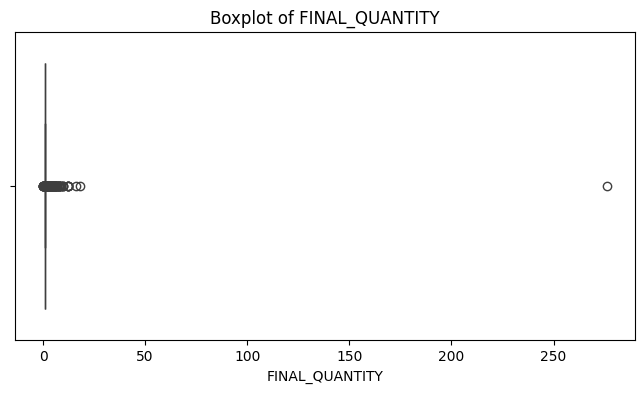

In [118]:
# Check descriptive statistics for FINAL_QUANTITY
print(Transactions["FINAL_QUANTITY"].describe())

# Boxplot for FINAL_QUANTITY
plt.figure(figsize=(8, 4))
sns.boxplot(x=Transactions["FINAL_QUANTITY"])
plt.title("Boxplot of FINAL_QUANTITY")
plt.show()

#### Data Quality Issue 7: Outliers in FINAL_QUANTITY

**Findings**:

 Analyzing the top 5% of FINAL_QUANTITY values revealed an outlier with **a quantity of 276 for MAIN STREET MARKET**, significantly exceeding other large transactions. No additional product details were available. Could MAIN STREET MARKET be a bulk sale store?

**Solution**:

Retain this data but confirm with upstream sources if the quantity is accurate or due to a system issue.


In [119]:
# Identify the top 5% FINAL_QUANTITY values to check for outliers
top_5_percent_threshold = Transactions["FINAL_QUANTITY"].quantile(0.95)

# Filter the records for the top 5% FINAL_QUANTITY
high_quantity_records = Transactions[Transactions["FINAL_QUANTITY"] >= top_5_percent_threshold]

# Sort the filtered records by FINAL_QUANTITY in descending order
high_quantity_sorted = high_quantity_records.sort_values(by="FINAL_QUANTITY", ascending=False)

# Display the top 10 records with relevant columns
print("\nTop 5% FINAL_QUANTITY records sorted by quantity:")
print(high_quantity_sorted[["FINAL_SALE", "FINAL_QUANTITY", "STORE_NAME", "BARCODE"]].head(10))


Top 5% FINAL_QUANTITY records sorted by quantity:
       FINAL_SALE  FINAL_QUANTITY            STORE_NAME       BARCODE
42302        5.89           276.0    MAIN STREET MARKET  048001353664
28576       64.44            18.0               WALMART  012005000077
37557       47.84            16.0             SHOP RITE  311111921628
45488       10.20            12.0                  ALDI           NaN
42319        2.28            12.0    FRESH THYME MARKET  748703280281
49630        6.24            12.0               WALMART  041789001215
26013       24.84            12.0               WALMART  078742371733
27976        2.00            12.0                SHAW'S  012000230677
42192        9.90            10.0                  ALDI           NaN
28691       13.50            10.0  DOLLAR GENERAL STORE  034000491087


In [120]:
# Investigate the highest FINAL_QUANTITY transaction (276 units)
barcode_target = "048001353664"
transaction_filtered = Transactions[Transactions["BARCODE"] == barcode_target]

# Merge with Products table to get category and brand information
product_info = transaction_filtered.merge(Products, on="BARCODE", how="left")

# Extract and display product information
product_info_selected = product_info[["BARCODE", "CATEGORY_1", "CATEGORY_2", "CATEGORY_3", "CATEGORY_4", "BRAND"]].drop_duplicates()

product_info_selected

,BARCODE,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,BRAND
0,048001353664,NaN,NaN,NaN,NaN,NaN


#### Data quality issues 8 and Challenge to Understand 4: Fractional FINAL_QUANTITY Values

**Findings**:

There are 80 transactions (0.32%) with **fractional FINAL_QUANTITY values**. Since items are typically sold in whole units (e.g., 1 bottle or 1 pack), these records appear unusual.

**Assumptions**:

These fractional quantities could result from **bulk purchases, weight-based pricing** (common in categories like Snacks, Health & Wellness, or Beverages), or potential data entry errors.

**Next Steps**:

Verify with the upstream team if fractional values are expected for these product categories. If confirmed as errors, consider rounding or flagging them for further review.

In [121]:
# Identify transactions where FINAL_QUANTITY is a fractional value (not a whole number)
float_quantity_rows = Transactions[Transactions["FINAL_QUANTITY"] % 1 != 0]
float_quantity_rows.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
26312,5d361872-cd98-46e7-bc54-bc109d542b6b,2024-06-15,2024-06-15 14:08:51.091,SPROUTS FARMERS MARKET,6149eb2d6d023a4236855e4c,000000940948,0.87,1.12
26852,459b41f8-ab7d-4569-9b0b-364e2dd97486,2024-06-13,2024-06-13 16:59:17.239,WALMART,62a28fae1f9dbf1584c6bf58,029000076501,0.62,2.98
26907,8954cbd0-b914-442e-bddf-eaf0e2b57cd3,2024-08-26,2024-08-27 05:54:13.705,WALMART,611b2092a04f5a70048b143b,735257005057,2.10,1.98
27122,3dbe1f4c-6649-47b0-8328-7fc893efbb31,2024-07-07,2024-07-08 15:58:08.868,KEY FOOD FRESH,5f299c8180f26b20811a4e70,000000040945,0.09,0.12
27205,c10f2a9a-c767-4ccf-ad84-3b11130c533a,2024-07-11,2024-07-14 04:46:46.793,SAFEWAY,5e189fb8daccde120591acb9,039400019725,3.33,3.99


In [122]:
# Count total records in Transactions
total_records = len(Transactions)

# Count records where FINAL_QUANTITY is fractional
fractional_quantities = Transactions[Transactions["FINAL_QUANTITY"] % 1 != 0]

# Count and calculate proportion
fractional_count = len(fractional_quantities)
fractional_ratio = (fractional_count / total_records) * 100

# Display results
fractional_summary = {
    "Total Records": total_records,
    "Fractional Quantity Records": fractional_count,
    "Fractional Quantity Percentage": round(fractional_ratio, 2)
}

print("Summary of Fractional Quantity Records:")
print(fractional_summary)

Summary of Fractional Quantity Records:
{'Total Records': 24790, 'Fractional Quantity Records': 80, 'Fractional Quantity Percentage': 0.32}


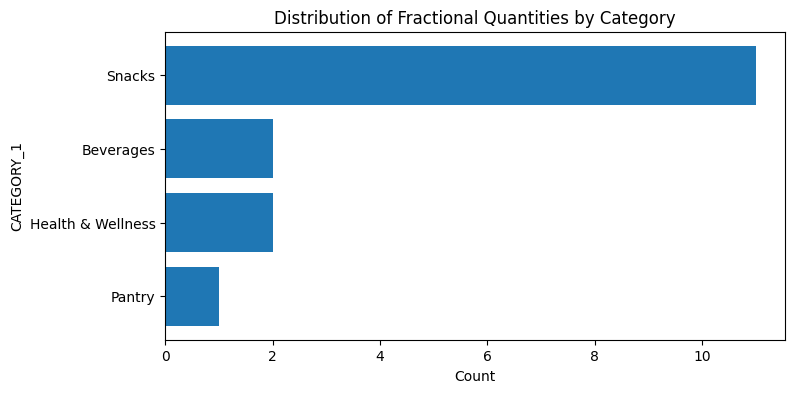

In [123]:
# Create temporary copies of Transactions and Products without affecting original data
temp_Transactions = Transactions.dropna(subset=["BARCODE"])
temp_Products = Products.dropna(subset=["BARCODE"])

# Merge Transactions with Products on BARCODE to get category information
transactions_with_categories = temp_Transactions.merge(temp_Products, on="BARCODE", how="left")

# Filter records where FINAL_QUANTITY is not an integer
transactions_with_fractional_quantity = transactions_with_categories[
    transactions_with_categories["FINAL_QUANTITY"] % 1 != 0
]

# Count the occurrences of each CATEGORY_1 for fractional quantities
fractional_quantity_category_counts = transactions_with_fractional_quantity["CATEGORY_1"].value_counts()

# Create DataFrame for plotting
fractional_quantity_category_df = pd.DataFrame({
    "CATEGORY_1": fractional_quantity_category_counts.index,
    "Count": fractional_quantity_category_counts.values
})

# Plot bar chart for fractional quantity category distribution
plt.figure(figsize=(8, 4))
plt.barh(fractional_quantity_category_df["CATEGORY_1"], fractional_quantity_category_df["Count"])
plt.xlabel("Count")
plt.ylabel("CATEGORY_1")
plt.title("Distribution of Fractional Quantities by Category")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


#### Challenge to Understand 5:

**Findings**:

The analysis above confirms that FINAL_SALE represents the total price rather than the unit price via below analysis. However, **FINAL_QUANTITY increases, but FINAL_SALE does not scale proportionally**, suggesting that pricing may be influenced by discounts, bulk pricing, or promotional offers, where buying more results in a lower per-unit cost.

**Next Steps**:

Further validation with the business team is recommended.

In [124]:
#Identify the FINAL_SALE is Unit price or total price

# Group transactions by BARCODE and compute quantity and sales statistics
barcode_stats = (
    Transactions.groupby("BARCODE")
    .agg(
        min_quantity=("FINAL_QUANTITY", "min"),  # Minimum quantity purchased per barcode
        max_quantity=("FINAL_QUANTITY", "max"),  # Maximum quantity purchased per barcode
        min_sale=("FINAL_SALE", "min"),  # Minimum FINAL_SALE recorded per barcode
        max_sale=("FINAL_SALE", "max")   # Maximum FINAL_SALE recorded per barcode
    )
    .reset_index()
)

# Identify BARCODEs where FINAL_QUANTITY varies (not fixed at a single value)
variable_quantity_barcodes = barcode_stats[barcode_stats["min_quantity"] != barcode_stats["max_quantity"]]["BARCODE"]

# Randomly sample 10 such BARCODEs for further analysis
sampled_barcodes = variable_quantity_barcodes.sample(n=10, random_state=42)

# Extract transactions corresponding to the sampled BARCODEs
sampled_transactions = Transactions[Transactions["BARCODE"].isin(sampled_barcodes)]

# Recalculate summary statistics for these transactions
sampled_analysis = (
    sampled_transactions.groupby("BARCODE")
    .agg(
        min_quantity=("FINAL_QUANTITY", "min"),
        max_quantity=("FINAL_QUANTITY", "max"),
        min_sale=("FINAL_SALE", "min"),
        max_sale=("FINAL_SALE", "max")
    )
    .reset_index()
)

# Display results
print(sampled_analysis)


        BARCODE  min_quantity  max_quantity  min_sale  max_sale
0  016000459601           1.0          4.00      1.96      9.96
1  021130284443           1.0          2.00      1.99      5.58
2  024100000197           1.0          2.00      5.07      6.00
3  029700001414           1.0          4.00      1.28      5.76
4  033474060010           1.0          2.00      3.29      5.00
5  041789002311           1.0          2.00      2.28      7.36
6  075900005264           1.0          2.00      4.34      6.58
7  076808280739           1.0          2.00      1.47      3.68
8  079400416490           1.0          2.00      8.87     22.98
9  511111503972           1.0          5.53      0.00     27.87


#### Data Quality Issue 9: Transactions with Low unit_price (0 - 0.1)

**Findings**:

 Some transactions have a unit price of 0, likely due to FINAL_SALE = 0, while others fall between **0 and 0.1**, which is unusually low. The CATEGORY_1 distribution for these transactions is similar to the overall data, suggesting potential causes like **free promotions, loyalty redemptions, or bulk pricing**.

**Next Steps**:

Further investigation with upstream data is needed to confirm if these are valid transactions or system errors.

In [125]:
# Calculate unit price as FINAL_SALE divided by FINAL_QUANTITY
Transactions["unit_price"] = Transactions["FINAL_SALE"] / Transactions["FINAL_QUANTITY"]

# Check basic statistics for unit price distribution
print(Transactions["unit_price"].describe())

count    24790.000000
mean         4.384913
std          6.307349
min          0.000000
25%          1.690000
50%          2.990000
75%          4.990000
max        462.820000
Name: unit_price, dtype: float64


In [126]:
# Identify transactions with unit_price between 0 and 0.1
unit_price_low = Transactions[(Transactions["unit_price"] >= 0) & (Transactions["unit_price"] < 0.1)]
print(f"Records with unit price between 0 and 0.1: {len(unit_price_low)}")
unit_price_low.head(5)  # Display sample records

Records with unit price between 0 and 0.1: 323


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,unit_price
25061,b4922d65-77d4-4910-ae7d-02120d8d6fe7,2024-07-17,2024-07-19 07:32:54.111,AMAZON,65a815c8b08449ff8da9f8ce,305731330380,1.0,0.0,0.0
25114,637c6547-6b0b-4933-bb6a-713b2ee9dd65,2024-07-15,2024-07-15 16:10:39.148,CVS,619989bf5889930cbd648e9c,NaN,1.0,0.0,0.0
25120,1520e298-4537-4721-a4c6-6d0dd178b43d,2024-07-06,2024-07-07 03:51:28.991,CVS,61fd3e573cb0d94dfb8cbcd4,NaN,1.0,0.0,0.0
25124,0fef37ef-fc91-4896-943c-1d7bde88a0eb,2024-07-15,2024-07-15 17:34:42.791,CVS,667700a6465f309038ac4b93,NaN,1.0,0.0,0.0
25128,b6b2862e-f8ca-4802-836d-e848b91cc964,2024-07-25,2024-08-01 13:57:32.288,CVS,6363e0b6d02459d8a57924f4,NaN,1.0,0.0,0.0


In [127]:
# Identify top 5% highest unit price transactions
unit_price_top_5 = Transactions[Transactions["unit_price"] >= Transactions["unit_price"].quantile(0.95)]
unit_price_top_5 = unit_price_top_5.sort_values(by="unit_price", ascending=False)
unit_price_top_5.head(5)  # Display sample high-price records

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,unit_price
26663,8bbb09f6-aae6-47ae-88af-7cd46cc8079d,2024-07-06,2024-07-06 10:01:20.305,CVS,630789e1101ae272a4852287,NaN,1.0,462.82,462.82
29371,8b4a1054-09e6-4701-a7b5-49e3db6b8f61,2024-08-23,2024-08-26 13:59:20.565,RITE AID,650874eafe41d365c2ee11d2,NaN,1.0,267.29,267.29
26204,bf4af9c2-ee08-48a1-ac97-1835f3f072f4,2024-08-29,2024-08-29 08:26:15.466,KROGER,63af23db9f3fc9c7546fdbec,NaN,1.0,238.17,238.17
28809,7f894472-dc11-4f4f-b994-8da1145a18b9,2024-07-17,2024-07-17 13:52:35.763,CVS,645add3bffe0d7e043ef1b63,NaN,1.0,224.99,224.99
38126,3c831a8f-7299-4906-a01d-d2b0d9a9b247,2024-07-10,2024-07-10 10:38:41.318,WALGREENS,6535138fdda97e6b1342ea7f,NaN,1.0,139.31,139.31


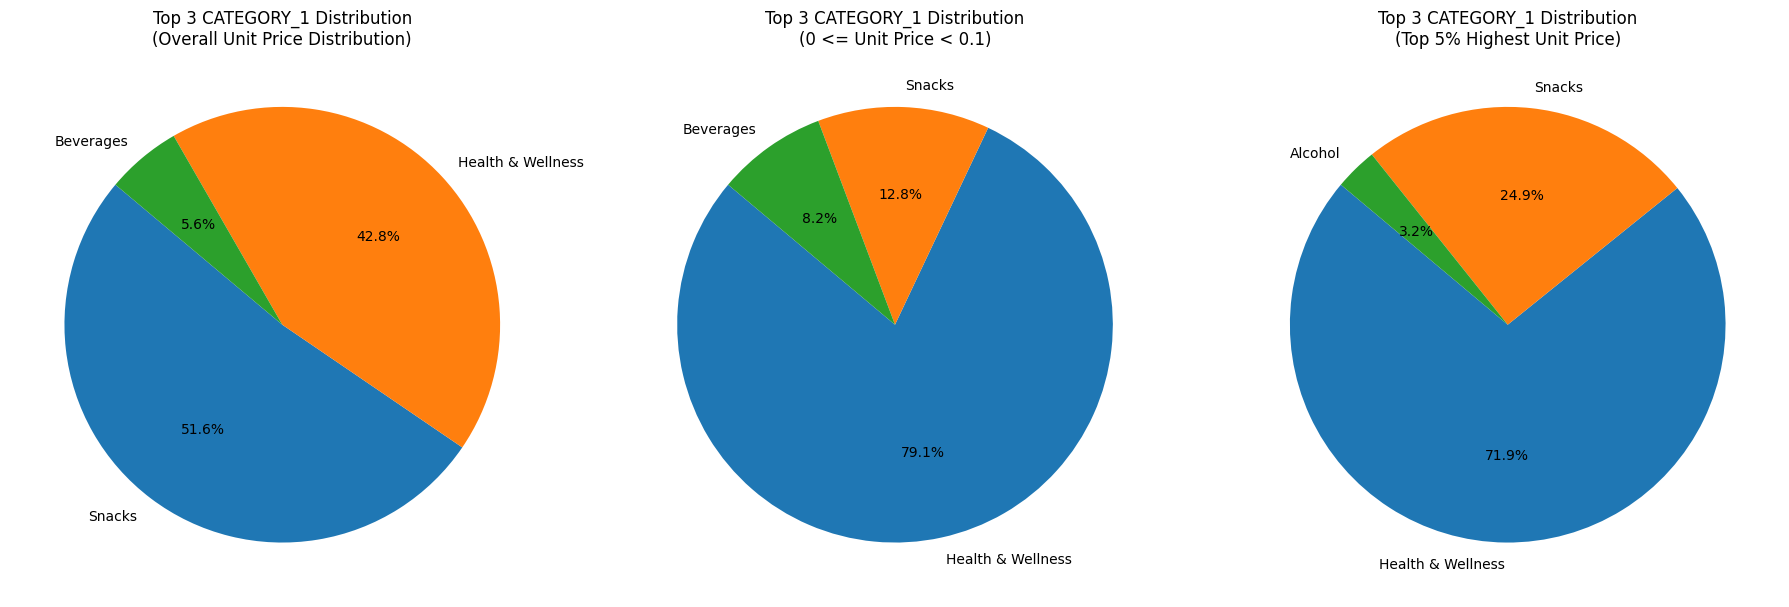

In [128]:
# Define different unit price ranges for comparison
unit_price_bins = {
    "Overall Unit Price Distribution": Transactions,
    "0 <= Unit Price < 0.1": unit_price_low,
    "Top 5% Highest Unit Price": unit_price_top_5
}

# Create visual comparison of top 3 CATEGORY_1 distributions for each unit price segment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (category, data) in zip(axes, unit_price_bins.items()):
    # Merge Transactions with Products to retrieve CATEGORY_1
    merged_data = data.merge(Products, on="BARCODE", how="left")

    # Count top 3 CATEGORY_1 occurrences
    category_distribution = merged_data["CATEGORY_1"].value_counts().head(3)

    # Plot pie chart for category distribution
    ax.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f"Top 3 CATEGORY_1 Distribution\n({category})")

plt.tight_layout()
plt.show()

## 6.Feature Engneering:Create AGE column

**Objective**:

To derive a new AGE feature from the BIRTH_DATE and CREATED_DATE fields. This feature is crucial for demographic analysis, segmentation, and understanding user behavior

**Steps:**

Step 1: Create AGE column

Step 2: Analyzing AGE Distribution

Step 3: Identify Outliers

In [129]:
#Step 1: Create AGE column
#Calculate AGE,Leave AGE as NaN if BIRTH_DATE is missing
def calculate_age(row):
    if pd.notnull(row["BIRTH_DATE"]) and pd.notnull(row["CREATED_DATE"]):
        return relativedelta(row["CREATED_DATE"], row["BIRTH_DATE"]).years
    else:
        return None

User["AGE"] = User.apply(calculate_age, axis=1)

# Display AGE distribution statistics
print(User["AGE"].describe())


count    96325.000000
mean        36.793719
std         15.171065
min          0.000000
25%         23.000000
50%         35.000000
75%         47.000000
max        121.000000
Name: AGE, dtype: float64


### Data Quality Issue 10: Unrealistic Age Entries

**Findings**:

Some users have extreme **ages (0-10, 100-121)** and no transaction activity. Additionally, there are noticeable patterns in BIRTH_DATE, with multiple entries like 1900-12-31 and 1901-01-01, suggesting default or placeholder values.

**Assumptions**:

These anomalies indicate that birth dates were likely **self-reported by users or system-generated** during registration, leading to potential inaccuracies in demographic analysis.

**Next Steps**:

Further validation is needed regarding Fetch’s data collection policies—whether users manually enter birth dates or if defaults are assigned.

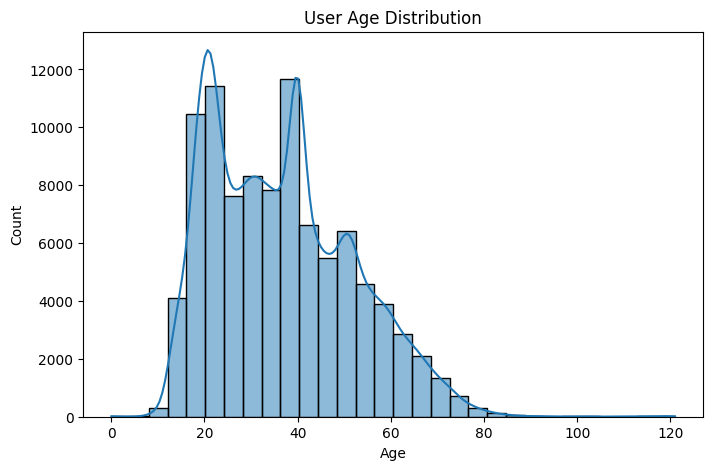

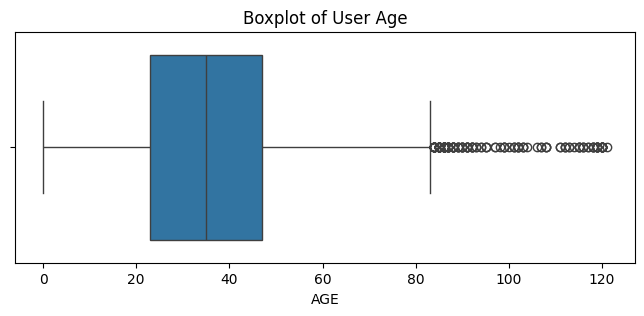

In [130]:
# Step 2: Analyzing AGE Distribution
# Visualizing AGE distribution
plt.figure(figsize=(8, 5))
sns.histplot(User["AGE"], bins=30, kde=True)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("User Age Distribution")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 3))
sns.boxplot(x=User["AGE"])
plt.title("Boxplot of User Age")
plt.show()

In [131]:
# Step 3: Identify Outliers

# Find the 15 oldest users to check for extreme values
oldest_users = User.nlargest(15, "AGE")
print("Top 15 Oldest Users:")
print(oldest_users[["ID", "BIRTH_DATE", "AGE", "STATE", "LANGUAGE", "GENDER"]])

# Find the 15 youngest users to check for unrealistic values
youngest_users = User.sort_values(by="BIRTH_DATE", ascending=False).head(15)
print("Top 15 Youngest Users:")
print(youngest_users[["ID", "BIRTH_DATE", "AGE", "STATE", "LANGUAGE", "GENDER"]])


Top 15 Oldest Users:
                             ID          BIRTH_DATE    AGE STATE LANGUAGE  \
30143  624a049c89dfe41b042fe072 1900-12-31 23:09:00  121.0    NC       en   
5878   60ac6acc79ed9200a6ebc24a 1901-05-24 18:09:00  120.0    UT      NaN   
59246  61281b41b0fef24601c0d38c 1900-12-31 23:09:00  120.0    ME      NaN   
59306  6108a98aa1ffea0b098ba933 1900-12-07 18:09:00  120.0    NY      NaN   
67071  656b3aaa9cb6a4f05dca27c1 1903-10-08 00:00:00  120.0    KS       en   
72938  60031045c47b5812a59f0a54 1901-01-12 23:09:00  120.0   NaN      NaN   
74297  62ba454a37e6e08b0775e779 1901-10-26 00:09:00  120.0    MO       en   
94185  601ad65d6c5786129e41840f 1901-01-01 00:09:00  120.0    AL      NaN   
98639  61a1127207acef7276e6158f 1900-12-31 23:09:00  120.0    PA       en   
98847  60bc0f11a3100c10461d86fa 1900-12-31 23:09:00  120.0    NY      NaN   
3656   62be5974baa38d1a1f6b6725 1902-12-31 23:00:00  119.0    PA       en   
6499   60a6e4af3369535cb6c4c89d 1901-10-12 18:09:00  11

In [133]:
# Drop records with missing BARCODE in both Transactions and Products tables before analysis
Transactions = Transactions.dropna(subset=["BARCODE"])
Products = Products.dropna(subset=["BARCODE"])

# Q2: Provide SQL Queries

## 1. What are the top 5 brands by receipts scanned among users 21 and over?

**Steps to Identify:**

1️⃣ Filter users who are 21 years or older.

2️⃣ Join transactions with product details for these users.

3️⃣ Count distinct receipts per brand and return the top 5.

**Findings:**

Based on the number of distinct receipts per brand, the top 5 brands scanned by users aged 21+ are:

NERDS CANDY – 3 times

DOVE – 3 times

TRIDENT – 2 times

SOUR PATCH KIDS – 2 times

MEIJER – 2 times



In [134]:
query = """
WITH Users_21_Plus AS (
    -- Step 1: Filter users who are 21 years or older
    SELECT ID FROM User WHERE AGE >= 21
),

Filtered_Transactions AS (
    -- Step 2: Filter transactions made by users 21+ and join with product details
    SELECT
        T.RECEIPT_ID, P.BRAND
    FROM Transactions T
    INNER JOIN Users_21_Plus U ON T.USER_ID = U.ID
    INNER JOIN Products P ON T.BARCODE = P.BARCODE
    WHERE P.BRAND IS NOT NULL  -- Ensure brands are not NULL
)

-- Step 3: Count the number of distinct receipts per brand and return the top 5 brands
SELECT
    BRAND,
    COUNT(DISTINCT RECEIPT_ID) AS unique_receipt_count
FROM Filtered_Transactions
GROUP BY BRAND
ORDER BY unique_receipt_count DESC
LIMIT 5;

"""

# Run SQL query
result = psql.sqldf(query, locals())
result

,BRAND,unique_receipt_count
0,NERDS CANDY,3
1,DOVE,3
2,TRIDENT,2
3,SOUR PATCH KIDS,2
4,MEIJER,2



## 2. What are the top 5 brands by sales among users that have had their account for at least six months?

**Steps to Identify:**

1️⃣ Filter users who have had their account for at least 6 months.

2️⃣ Select transactions that happened after the user’s 6-month anniversary.

3️⃣ Aggregate total sales per brand.

4️⃣ Sort and retrieve the top 5 brands by total sales.

**Findings:**

The top 5 brands by total sales from users who have been active for at least 6 months are:

CVS – $72.00

DOVE – $30.91

TRIDENT – $23.36

COORS LIGHT – $17.48

TRESEMMÉ – $14.58






In [135]:
query = """
WITH Users_6_Months AS (
    -- Step 1: Identify users who have had their account for at least 6 months
    SELECT
        ID,
        DATE(CREATED_DATE) AS CREATED_DATE,
        DATE(CREATED_DATE, '+180 days') AS Six_Month_Anniversary
    FROM User  -- Make sure this matches the actual table name
),
Filtered_Transactions AS (
    -- Step 2: Filter transactions that happened after the user's 6-month anniversary
    SELECT T.*
    FROM Transactions T
    INNER JOIN Users_6_Months U
        ON T.USER_ID = U.ID
    WHERE DATE(T.PURCHASE_DATE) >= U.Six_Month_Anniversary
),
Brand_Sales AS (
    -- Step 3: Aggregate sales per brand
    SELECT P.BRAND, SUM(T.FINAL_SALE) AS total_sales
    FROM Filtered_Transactions T
    INNER JOIN Products P ON T.BARCODE = P.BARCODE
    WHERE P.BRAND IS NOT NULL
    GROUP BY P.BRAND
)
-- Step 4: Get the top 5 brands by sales
SELECT BRAND, total_sales
FROM Brand_Sales
ORDER BY total_sales DESC
LIMIT 5;

"""

# Run SQL query
result = psql.sqldf(query, locals())
result

,BRAND,total_sales
0,CVS,72.00
1,DOVE,30.91
2,TRIDENT,23.36
3,COORS LIGHT,17.48
4,TRESEMMÉ,14.58


## 3. What is the percentage of sales in the Health & Wellness category by generation?

**Steps to Identify:**

Step 1: Assign generation groups based on AGE

Step 2: Join User, Transactions, and Products tables

Step 3:Filter only transactions related to "Health & Wellness" category

Step 4: Calculate total sales across all generations in "Health & Wellness"

Step 5: Calculate the percentage of sales in Health & Wellness per generation

**Findings:**

Our analysis of sales data in the Health & Wellness category shows that **Baby Boomers** (1946-1964) are the leading consumer group, contributing **52.71%** of total sales. **Millennials** (1981-1996) follow with **31.18%**, while **Gen X** (1965-1980) accounts for **16.11%**. Notably, there are **no recorde**d sales from the **Silent Generation** (Before 1946).

In [136]:
query = """
WITH User_Generations AS (
    -- Step 1: Assign generation groups based on AGE
    SELECT
        ID,
        AGE,
        CASE
            WHEN AGE >= 75 THEN 'Silent Gen (Before 1946)'
            WHEN AGE >= 59 THEN 'Baby Boomers (1946-1964)'
            WHEN AGE >= 43 THEN 'Gen X (1965-1980)'
            WHEN AGE >= 27 THEN 'Millennials (1981-1996)'
            ELSE 'Gen Z (1997 and later)'
        END AS GENERATION
    FROM User
),
Merged_Data AS (
    -- Step 2: Join User, Transactions, and Products tables
    SELECT
        U.GENERATION,
        P.CATEGORY_1,
        T.FINAL_SALE
    FROM Transactions T
    INNER JOIN User_Generations U ON T.USER_ID = U.ID
    LEFT JOIN Products P ON T.BARCODE = P.BARCODE
),
Health_Sales AS (
    -- Step 3:Filter only transactions related to "Health & Wellness" category
    SELECT
        GENERATION,
        SUM(FINAL_SALE) AS total_sales
    FROM Merged_Data
    WHERE CATEGORY_1 = 'Health & Wellness'
    GROUP BY GENERATION
),
Total_Sales AS (
    -- Step 4: Calculate total sales across all generations in "Health & Wellness"
    SELECT SUM(total_sales) AS overall_sales FROM Health_Sales
)
-- Step 5: Calculate the percentage of sales in Health & Wellness per generation
SELECT
    H.GENERATION,
    (H.total_sales / T.overall_sales) * 100 AS percentage_of_sales
FROM Health_Sales H
CROSS JOIN Total_Sales T
ORDER BY percentage_of_sales DESC;

"""

# Run SQL query
result = psql.sqldf(query, locals())
result


,GENERATION,percentage_of_sales
0,Baby Boomers (1946-1964),52.707785
1,Millennials (1981-1996),31.183402
2,Gen X (1965-1980),16.108813


## 4. Who are Fetch’s power users?

**Assumptions:**

**Recency (R)** is not a key differentiator because all users in the dataset (June–September 2024) have interacted recently.

**Frequency (F)** is the primary factor—frequent shoppers are more engaged and loyal.

**Monetary (M)** is the secondary factor—higher total spending suggests higher value to Fetch.

A power user is defined as **a user who shops frequently (high purchase count) and spends a significant amount (monetary value).**

**Steps to Identify Power Users:**

1️⃣ Aggregate transaction data to calculate Frequency (F) and Monetary (M) per user.

2️⃣ Sort users by purchase frequency first, then by total spending to prioritize engagement.

**Findings:**

The **top power user (ID: 62925c1be942f00613f7365e)** has made **10 transactions, spending $27.61**.

Other power users have **6-9 purchases**, with total spending ranging from **$15.55 - $57.21**.

The user with ID: 5d77d06b0d1bff4316a3ef47 stands out with a moderate purchase count (6) but the highest total spending ($57.21), indicating high-value purchases.


In [137]:
query = """
WITH User_Spending AS (
    -- Step 1: Aggregate transaction data to calculate Frequency (F) and Monetary (M) per user
    SELECT
        USER_ID,
        COUNT(DISTINCT RECEIPT_ID) AS purchase_count,  -- Frequency: Number of unique purchases
        SUM(FINAL_SALE) AS total_spent  -- Monetary: Total amount spent
    FROM Transactions
    GROUP BY USER_ID
)
-- Step 2: Sort users by purchase frequency first, then by total spending
SELECT
    USER_ID,
    purchase_count,
    total_spent
FROM User_Spending
ORDER BY purchase_count DESC, total_spent DESC
LIMIT 10;

"""

# Run SQL query
result = psql.sqldf(query, locals())
result

,USER_ID,purchase_count,total_spent
0,62925c1be942f00613f7365e,10,27.61
1,64063c8880552327897186a5,9,30.61
2,609af341659cf474018831fb,7,14.34
3,6327a07aca87b39d76e03864,7,12.54
4,5d77d06b0d1bff4316a3ef47,6,57.21
5,605a982894a5c74ba439e5ab,6,41.89
6,5eb59d6be7012d13941af5e2,6,34.99
7,6682cbf6465f309038ae1888,6,29.57
8,62b6189d37e6e08b0774ce73,6,24.96
9,624dca0770c07012cd5e6c03,6,15.55


## Which is the leading brand in the Dips & Salsa category?

**Assumptions:**

"Leading brand" is determined by the **highest total FINAL_SALE** in the Dips & Salsa category.

The CATEGORY_2 column in the Products table identifies the "Dips & Salsa" category.


**Steps:**

Step 1: Join Transactions and Products tables to filter relevant transactions in the "Dips & Salsa" category

Step 2: Retrieve the top-selling brand in the category

**Findings:**

Based on the assumption, **TOSTITOS**	is the leading brand in the Dips & Salsa category with **$181.3 toal sales.**

In [138]:
query = """
WITH Dips_Sales AS (
    -- Step 1: Join Transactions and Products tables to filter relevant transactions in the "Dips & Salsa" category
    SELECT
        P.BRAND,
        SUM(T.FINAL_SALE) AS total_sales
    FROM Transactions T
    INNER JOIN Products P ON T.BARCODE = P.BARCODE
    WHERE P.CATEGORY_2 = 'Dips & Salsa'
    GROUP BY P.BRAND
)
-- Step 2: Retrieve the top-selling brand in the category
SELECT BRAND, total_sales
FROM Dips_Sales
ORDER BY total_sales DESC
LIMIT 1;
"""

# Run SQL query
result = psql.sqldf(query, locals())
result



,BRAND,total_sales
0,TOSTITOS,181.3


# Q3: One interesting trend in the data

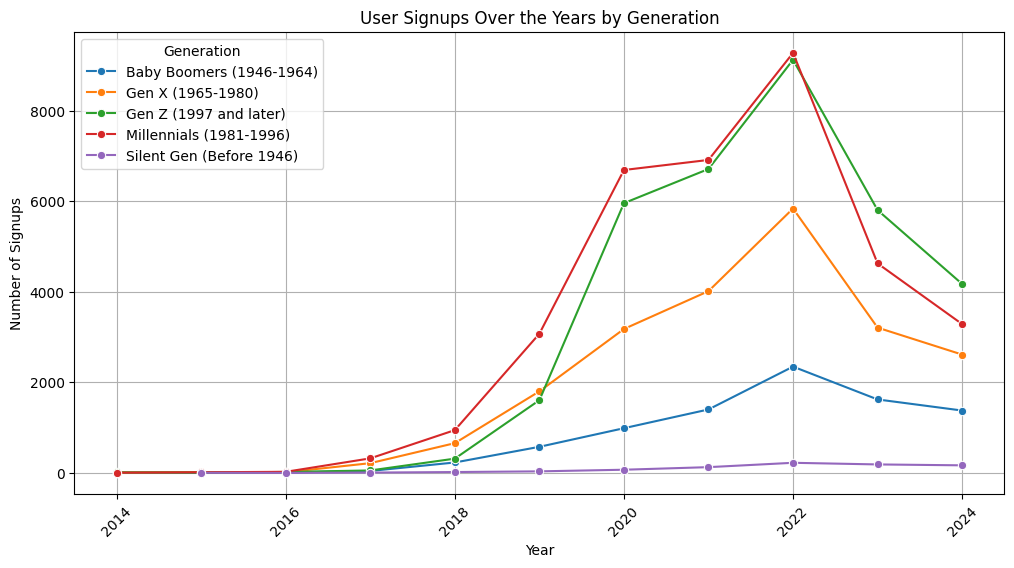

In [140]:
 #Extract year for trend analysis
User["CREATED_YEAR"] = User["CREATED_DATE"].dt.year

# Define a function to assign generation groups
def assign_generation(age):
    if age >= 75:
        return "Silent Gen (Before 1946)"
    elif age >= 59:
        return "Baby Boomers (1946-1964)"
    elif age >= 43:
        return "Gen X (1965-1980)"
    elif age >= 27:
        return "Millennials (1981-1996)"
    else:
        return "Gen Z (1997 and later)"

# Apply the function to create a new column in the User DataFrame
User["GENERATION"] = User["AGE"].apply(assign_generation)

# Group by year and generation to count user signups
signup_trend_gen = User.groupby(["CREATED_YEAR", "GENERATION"])["ID"].count().reset_index()
signup_trend_gen.columns = ["Year", "Generation", "User Signups"]

# Plot user signup trend over the years for different generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=signup_trend_gen, x="Year", y="User Signups", hue="Generation", marker="o")
plt.xticks(rotation=45)
plt.title("User Signups Over the Years by Generation")
plt.xlabel("Year")
plt.ylabel("Number of Signups")
plt.grid()
plt.legend(title="Generation")

plt.show()

## Insights from User Signups by Generation

Analyzing Fetch Rewards user growth by generation reveals key trends:

**Millennials** (1981-1996) and **Gen Z** (1997 and later) drove the most signups, peaking in 2022.


Gen X (1965-1980) and Baby Boomers (1946-1964) showed steady growth but at lower rates, indicating slower adoption.

Silent Gen (Before 1946) had minimal signups, likely due to lower tech adoption.

Peak in 2022 & Decline Afterward:

The sharp increase in 2020-2022 could be linked to **pandemic**-driven e-commerce growth.

The drop after 2022 may indicate market saturation, economic shifts, or reduced marketing effectiveness.

**Next Steps:**

Target retention strategies for Millennials and Gen Z to maintain engagement.

Explore new acquisition tactics for Gen X and Baby Boomers.
Analyze 2022 marketing campaigns to understand what drove peak growth.

**Conclusion:**

Millennials and Gen Z have been the primary drivers of Fetch Rewards' growth, but recent declines suggest the need for retention-focused efforts and diversification in user acquisition strategies.